# ETTh2 Univariate Forecasting (H=48)

This notebook implements the **Boosted Hybrid Model**:
- Sinusoidal Regressor (linear regression with sine/cos features)
- Residual modeling with XGBoost

Dataset: **ETTh2 (hourly data)**, univariate forecasting with horizon H=48.


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# For reproducibility
np.random.seed(42)


In [10]:

# Load ETTh1 dataset (CSV available in many repos)
# If not downloaded, fetch from https://github.com/zhouhaoyi/ETDataset
file_path = "/kaggle/input/ETTh2.csv"

# Load the dataset
data = pd.read_csv(file_path)

print("Columns:", data.columns)
print("Shape:", data.shape)
data.head()


Columns: Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')
Shape: (17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500


In [11]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,37.193346,8.537565,43.830356,8.322694,-3.423605,-2.085969,26.609376
std,10.218855,6.020442,13.056798,4.366059,6.144403,6.012796,11.888266
min,0.000000,-18.680000,11.205000,-6.594000,-14.350000,-31.462000,-2.646500
25%,30.156000,4.523000,37.394001,5.683000,-9.254000,-2.505000,16.469500
50%,37.193001,9.131000,41.388000,9.302000,-3.774000,-1.226000,26.577000
75%,44.062000,13.152000,46.078999,11.258000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,28.736000,17.218000,2.932000,58.876999


In [12]:
data.isnull().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

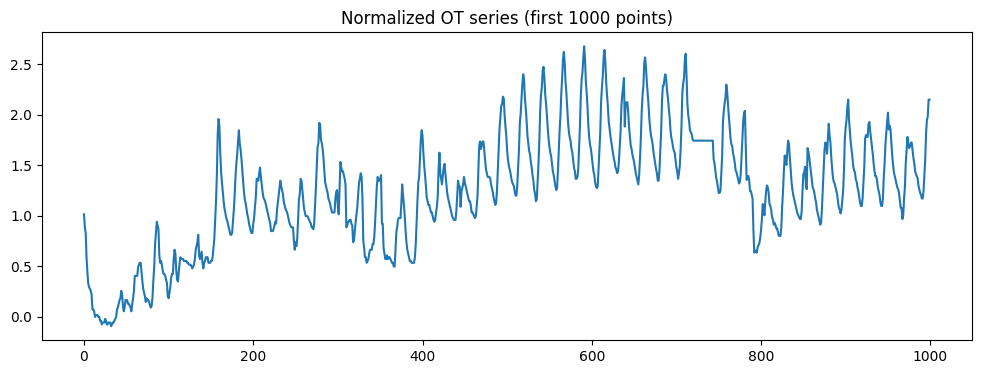

In [13]:

# Use univariate column (oil temperature: 'OT')
series = data['OT'].values

# Normalize (z-score)
mean, std = series.mean(), series.std()
series_norm = (series - mean) / std

plt.figure(figsize=(12,4))
plt.plot(series_norm[:1000])
plt.title("Normalized OT series (first 1000 points)")
plt.show()


In [14]:

def create_dataset(series, input_len=168, horizon=24):
    X, y = [], []
    for i in range(len(series) - input_len - horizon):
        X.append(series[i:i+input_len])
        y.append(series[i+input_len:i+input_len+horizon])
    return np.array(X), np.array(y)

# Configurable horizon
horizon = 48  
input_len = 168  # past window length

# Assume series_norm is your normalized univariate series
X, y = create_dataset(series_norm, input_len, horizon)
print("X shape:", X.shape, "y shape:", y.shape)

# TS2Vec-style chronological split for ETTh1
# Each month ≈ 30 days * 24 hours = 720 time steps
train_end = 12 * 30 * 24   # 12 months
val_end   = 16 * 30 * 24   # 16 months (12+4)
test_end  = 20 * 30 * 24   # 20 months (12+4+4)

# Map indices to dataset windows
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:test_end], y[val_end:test_end]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



X shape: (17204, 168) y shape: (17204, 48)
Train: (8640, 168) Val: (2880, 168) Test: (2880, 168)


In [15]:

def add_sin_features(n_samples, horizon, period=24):
    # For each time step ahead, add sin/cos with period
    t = np.arange(horizon)
    sin_feat = np.sin(2*np.pi*t/period)
    cos_feat = np.cos(2*np.pi*t/period)
    return np.vstack([sin_feat, cos_feat]).T

# Create features for sinusoidal regressor (same for all samples)
sin_features = add_sin_features(len(y_train), horizon)
print("Sinusoidal feature shape (per sample):", sin_features.shape)


Sinusoidal feature shape (per sample): (48, 2)


In [16]:

# Fit linear regression on sinusoidal features (predicts trend)
linreg = LinearRegression()
# Repeat features for all training samples
X_sin = np.tile(sin_features, (len(y_train),1))
y_train_flat = y_train.flatten()

linreg.fit(X_sin, y_train_flat)

# Predictions
y_train_pred_sin = linreg.predict(X_sin).reshape(len(y_train), horizon)


In [17]:

# Compute residuals
residuals = y_train - y_train_pred_sin

# Use lag features (X_train) for XGBoost
X_train_flat = X_train.reshape(len(X_train), -1)
residuals_flat = residuals.reshape(len(residuals), -1)

# Train XGBoost to predict residuals (multi-output: predict each horizon step separately)
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=5, tree_method='hist')
xgb_model.fit(X_train_flat, residuals_flat)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:

def evaluate(X_set, y_set):
    # Sinusoidal prediction
    X_sin_eval = np.tile(sin_features, (len(y_set),1))
    y_pred_sin = linreg.predict(X_sin_eval).reshape(len(y_set), horizon)

    # Residual correction
    X_flat = X_set.reshape(len(X_set), -1)
    res_pred = xgb_model.predict(X_flat).reshape(len(y_set), horizon)

    y_pred = y_pred_sin + res_pred

    mse = mean_squared_error(y_set.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_set.flatten(), y_pred.flatten())
    return mse, mae, y_pred

mse_val, mae_val, _ = evaluate(X_val, y_val)
mse_test, mae_test, y_test_pred = evaluate(X_test, y_test)

print(f"Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")


Validation MSE: 0.1342, MAE: 0.2746
Test MSE: 0.1232, MAE: 0.2698


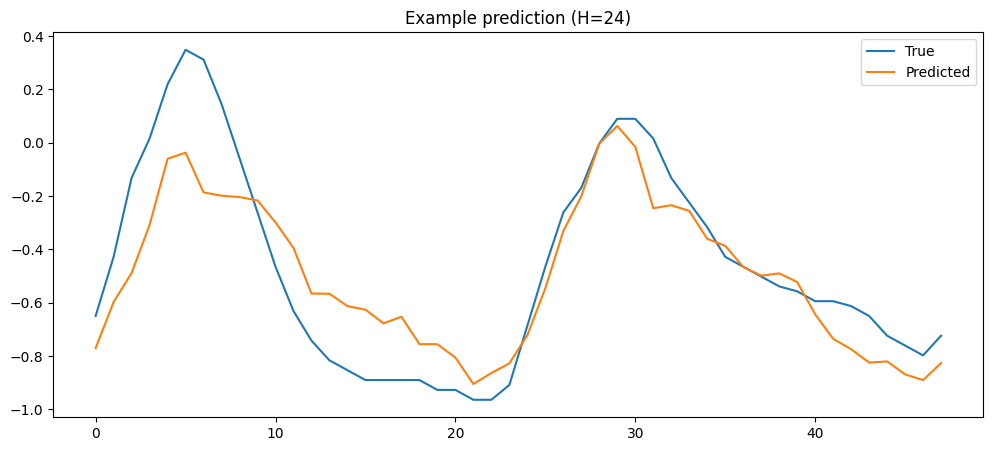

In [19]:

plt.figure(figsize=(12,5))
plt.plot(y_test[105], label="True")
plt.plot(y_test_pred[105], label="Predicted")
plt.legend()
plt.title("Example prediction (H=24)")
plt.show()
